In [58]:
import pandas as pd
pd.set_option('display.max_columns', None)

import requests
import re
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import font_manager
import os

In [6]:
api_key_kaveh = 'JRLl3R4GkcNCPAmwzo4vfUIfwttQbJlcv3ghqaJg'

In [7]:
# Sample query lists
original_list = ["ENFUVIRTIDE", "VALCYTE"]
drug_query_list = ['FLUOXETINE', 'PHENELZINE']
# Our base url
adverse_events_url = "https://api.fda.gov/drug/event.json?"
# Filter category
medicinal_product = "patient.drug.medicinalproduct"

In [8]:
def create_url(query_list, base_url, api_key, filter_category, query_limit=240):
    list_length = len(query_list)
    url_plus_api = f"{base_url}api_key={api_key}&search="
    
    for term in query_list:
        url_plus_api += filter_category + f':"{term}"'
        list_length -= 1
        if list_length != 0:
            url_plus_api += "+AND+"
            
    url_plus_api_plus_filter = url_plus_api + f"&limit={query_limit}"

    return url_plus_api_plus_filter

In [9]:
fluoxetine = create_url(drug_query_list, adverse_events_url, api_key_kaveh, medicinal_product)

In [10]:
def get_and_validate_response(url):
    response = requests.get(url)
    if response.status_code == 200:
        print("Success!")
        return response
    else:
        print("Fail")
        return None

In [11]:
data_json = get_and_validate_response(fluoxetine).json()
results = data_json.get('results', [])

Success!


In [12]:
df = pd.json_normalize(results)

In [13]:
df.head(100)

,safetyreportversion,safetyreportid,primarysourcecountry,occurcountry,transmissiondateformat,transmissiondate,reporttype,serious,receivedateformat,receivedate,receiptdateformat,receiptdate,fulfillexpeditecriteria,companynumb,duplicate,reportduplicate.duplicatesource,reportduplicate.duplicatenumb,primarysource.reportercountry,primarysource.qualification,sender.sendertype,sender.senderorganization,receiver.receivertype,receiver.receiverorganization,patient.patientonsetage,patient.patientonsetageunit,patient.patientsex,patient.reaction,patient.drug,seriousnesshospitalization,seriousnessdisabling,primarysource.literaturereference,patient.patientagegroup,seriousnessother,seriousnessdeath,seriousnesslifethreatening,seriousnesscongenitalanomali,patient.summary.narrativeincludeclinical
0,1,10235075,US,US,102,20141212,1,2,102,20140613,102,20140613,2,US-009507513-1406USA003372,1,MERCK,US-009507513-1406USA003372,US,1,2,FDA-Public Use,6,FDA,82,801,1,"[{'reactionmeddraversionpt': '17.0', 'reaction...","[{'drugcharacterization': '1', 'medicinalprodu...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,5,10726369,US,US,102,20170829,1,2,102,20150121,102,20170524,2,US-PFIZER INC-2015019537,1,PFIZER,US-PFIZER INC-2015019537,US,5,2,FDA-Public Use,6,FDA,NaN,NaN,2,"[{'reactionmeddraversionpt': '20.0', 'reaction...","[{'drugcharacterization': '1', 'medicinalprodu...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,14276293,US,US,102,20180321,1,1,102,20171211,102,20171211,1,US-OTSUKA-2016_005097,1,OTSUKA,US-OTSUKA-2016_005097,US,5,2,FDA-Public Use,6,FDA,NaN,NaN,1,"[{'reactionmeddraversionpt': '20.1', 'reaction...","[{'drugcharacterization': '2', 'medicinalprodu...",1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2,15685235,IE,IE,102,20190417,1,1,102,20181204,102,20190305,1,IE-009507513-1811IRL011820,1,MERCK,IE-009507513-1811IRL011820,IE,1,2,FDA-Public Use,6,FDA,55,801,2,"[{'reactionmeddraversionpt': '21.1', 'reaction...","[{'drugcharacterization': '1', 'medicinalprodu...",1,NaN,"O^LEARY J, PURCELL A, HYNES C, HUET J, ROMANOS...",NaN,NaN,NaN,NaN,NaN,NaN
4,3,15724405,IE,IE,102,20191004,1,1,102,20181214,102,20190814,1,IE-BAUSCH-BL-2018-034714,1,BAUSCH AND LOMB,IE-BAUSCH-BL-2018-034714,IE,1,2,FDA-Public Use,6,FDA,55,801,2,"[{'reactionmeddraversionpt': '22.0', 'reaction...","[{'drugcharacterization': '1', 'medicinalprodu...",1,NaN,"O^LEARY J, PURCELL A, HYNES C, HUET J, ROMANOS...",NaN,NaN,NaN,NaN,NaN,NaN
5,1,16672775,IE,IE,102,20191004,1,1,102,20190806,102,20190806,1,IE-MYLANLABS-2019M1072971,1,MYLAN,IE-MYLANLABS-2019M1072971,IE,1,2,FDA-Public Use,6,FDA,55,801,2,"[{'reactionmeddraversionpt': '22.0', 'reaction...","[{'drugcharacterization': '1', 'medicinalprodu...",1,NaN,"O^LEARY J, PURCELL A, HYNES C, HUET J, ROMANOS...",NaN,NaN,NaN,NaN,NaN,NaN
6,1,19458510,US,US,102,20210717,1,1,102,20210624,102,20210624,1,US-MYLANLABS-2021M1037459,1,MYLAN,US-MYLANLABS-2021M1037459,US,1,2,FDA-Public Use,6,FDA,NaN,NaN,2,"[{'reactionmeddraversionpt': '24.0', 'reaction...","[{'drugcharacterization': '1', 'medicinalprodu...",1,NaN,"JANSEN MO, L^ECUYER S. NOVEL USE OF CLOZAPINE ...",4,NaN,NaN,NaN,NaN,NaN
7,1,19468088,US,US,102,20210717,1,1,102,20210628,102,20210628,1,US-DRREDDYS-LIT/USA/21/0136878,1,DR REDDYS,US-DRREDDYS-LIT/USA/21/0136878,US,3,2,FDA-Public Use,6,FDA,NaN,NaN,2,"[{'reactionmeddraversionpt': '24.0', 'reaction...","[{'drugcharacterization': '1', 'medicinalprodu...",1,NaN,"JANSEN M, L^ECUYER S. NOVEL USE OF CLOZAPINE F...",4,1,NaN,NaN,NaN,NaN
8,1,19479680,US,US,102,20211014,1,1,102,20210701,102,20210701,2,US-LUPIN PHARMACEUTICALS INC.-2021-10546,1,LUPIN,US-LUPIN PHARMACEUTICALS INC.-2021-10546,US,1,2,FDA-Public Use,6,FDA,NaN,NaN,2,"[{'reactionmeddraversionpt': '24.0', 'reaction...","[{'drugcharacterization': '1', 'medicinalprodu...",1,NaN,NaN,4,NaN,NaN,NaN,NaN,NaN
9,2,19511437,US,US,102,20211014,1,1,102,20210709,102,20210727,1,US-AUROBINDO-AUR-APL-2021-028990,1,AUROBINDO,US-AUROBINDO-AUR-APL-2021-028990,US,1,2,FDA-Public Use,6,FDA,NaN,NaN,2,"[{'reactionmeddraversionpt': '24.0', 'reaction...","

In [14]:
df1 = df.copy()

In [15]:
# Extract serious column names
serious_cols = []
for col in df1.columns:
    if re.search("serious", col):
        serious_cols.append(col)

print(serious_cols)

['serious', 'seriousnesshospitalization', 'seriousnessdisabling', 'seriousnessother', 'seriousnessdeath', 'seriousnesslifethreatening', 'seriousnesscongenitalanomali']


In [16]:
top_features = [
    "patient.patientsex",
    "patient.patientonsetage",
    "patient.drug",
    "patient.reaction"
]

for col in serious_cols:
    top_features.append(col)

df1 = df1[top_features]

df1['drug_info'] = df1['patient.drug'].apply(
    lambda drugs: [(d.get('medicinalproduct'), d.get('drugcharacterization')) for d in drugs])

df1['observed_reactions'] = df1['patient.reaction'].apply(
    lambda reactions: [reaction.get('reactionmeddrapt') for reaction in reactions])

In [18]:
drop_cols = ['patient.drug', 'patient.reaction']
df2 = df1.copy()
df2 = df2.drop(drop_cols, axis=1)
df2.head()

,patient.patientsex,patient.patientonsetage,serious,seriousnesshospitalization,seriousnessdisabling,seriousnessother,seriousnessdeath,seriousnesslifethreatening,seriousnesscongenitalanomali,drug_info,observed_reactions
0,1,82,2,NaN,NaN,NaN,NaN,NaN,NaN,"[(MIRTAZAPINE, 1), (DIAZEPAM, 1), (FLUOXETINE,...",[Drug ineffective]
1,2,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,"[(ATROPINE SULFATE., 1), (BELLERGAL-S, 1), (EL...",[Drug hypersensitivity]
2,1,NaN,1,1,1,NaN,NaN,NaN,NaN,"[(LITHIUM., 2), (PHENELZINE SULFATE., 2), (PRO...","[Off label use, Agraphia]"
3,2,55,1,1,NaN,NaN,NaN,NaN,NaN,"[(AMITRIPTYLINE HYDROCHLORIDE., 1), (PHENELZIN...",[Therapy non-responder]
4,2,55,1,1,NaN,NaN,NaN,NaN,NaN,"[(SERTRALINE HYDROCHLORIDE., 1), (DULOXETINE H...",[Therapy non-responder]


In [19]:
# converting patientonsetage to integer
def integer_conversion(str_input):
    if pd.notna(str_input):
        return int(str_input)
    else:
        return np.nan

def serious_conversion(str_input):
    if pd.notna(str_input):
        return int(str_input)
    else:
        return 0
    
df3 = df2.copy()

select_cols = list(df3.columns)[:2]

for col in select_cols:
    df3[col] = df3[col].apply(integer_conversion)

for col in serious_cols:
    df3[col] = df3[col].apply(serious_conversion)

df3['patient.patientonsetage'] = df3['patient.patientonsetage'].fillna(df3['patient.patientonsetage'].median())

df3.head()

,patient.patientsex,patient.patientonsetage,serious,seriousnesshospitalization,seriousnessdisabling,seriousnessother,seriousnessdeath,seriousnesslifethreatening,seriousnesscongenitalanomali,drug_info,observed_reactions
0,1,82.0,2,0,0,0,0,0,0,"[(MIRTAZAPINE, 1), (DIAZEPAM, 1), (FLUOXETINE,...",[Drug ineffective]
1,2,43.0,2,0,0,0,0,0,0,"[(ATROPINE SULFATE., 1), (BELLERGAL-S, 1), (EL...",[Drug hypersensitivity]
2,1,43.0,1,1,1,0,0,0,0,"[(LITHIUM., 2), (PHENELZINE SULFATE., 2), (PRO...","[Off label use, Agraphia]"
3,2,55.0,1,1,0,0,0,0,0,"[(AMITRIPTYLINE HYDROCHLORIDE., 1), (PHENELZIN...",[Therapy non-responder]
4,2,55.0,1,1,0,0,0,0,0,"[(SERTRALINE HYDROCHLORIDE., 1), (DULOXETINE H...",[Therapy non-responder]


In [60]:
font_path = os.path.join(
    os.path.expanduser("~"),
    "uncommon-hacks-proj",
    "adversacare",
    "src",
    "assets",
    "Albert_Sans",
    "static",
    "AlbertSans-Bold.ttf"
)

font_prop = font_manager.FontProperties(fname=font_path)

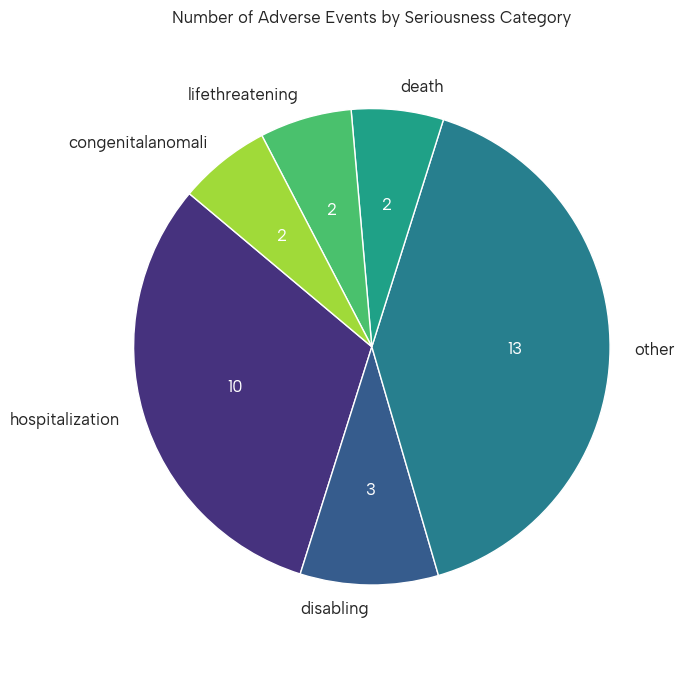

In [75]:
# clean and prepare dataframe
df_seriousness = df3.copy()
df_seriousness = df_seriousness[serious_cols]

# Safely drop 'serious' column if it exists
if 'serious' in df_seriousness.columns:
    df_seriousness = df_seriousness.drop('serious', axis=1)

# Clean up column names (remove 'seriousness' prefix)
df_seriousness.columns = df_seriousness.columns.str.replace(r'^seriousness', '', regex=True)

# count non-zero values
seriousness_counts = (df_seriousness != 0).sum()
seriousness_counts = seriousness_counts[seriousness_counts > 0]  # remove 0-only columns (optional)

# Load custom font
font_path = os.path.join(
    os.getcwd(),
    "adversacare",
    "src",
    "assets",
    "Albert_Sans",
    "AlbertSans-VariableFont_wght.ttf"
)

if not os.path.isfile(font_path):
    raise FileNotFoundError(f"Font not found at: {font_path}")

font_prop = font_manager.FontProperties(fname=font_path)

# plot pie chart
sns.set_theme()  # optional: use seaborn theme
colors = sns.color_palette("viridis", n_colors=len(seriousness_counts))

fig, ax = plt.subplots(figsize=(7, 7))
wedges, texts, autotexts = ax.pie(
    seriousness_counts,
    labels=seriousness_counts.index,
    autopct=lambda p: f'{int(round(p * seriousness_counts.sum() / 100))}',
    startangle=140,
    colors=colors,
    textprops={'fontsize': 14, 'fontproperties': font_prop}
)

# Style the text inside the slices
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontsize(14)
    autotext.set_fontproperties(font_prop)

# Title styling
ax.set_title(
    "Number of Adverse Events by Seriousness Category",
    fontsize=18,
    fontweight='bold',
    fontproperties=font_prop
)

ax.axis('equal')  # keep the pie circular
plt.tight_layout()
plt.show()
